In [96]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline

In [97]:
LABELS = [0, 0, 1, 1]
CENTERS = [(-3, -3), (3, 3), (3, -3), (-3, 3)]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [98]:
# Defining the model
class MultilayerPerceptron(nn.Module):
    def __init__(self, input_size, hidden_size=2, output_size=3,
                 num_hidden_layers=1, hidden_activation=nn.Sigmoid):
        """Initialize weights.

        Args:
            input_size (int): size of the input
            hidden_size (int): size of the hidden layers
            output_size (int): size of the output
            num_hidden_layers (int): number of hidden layers
            hidden_activation (torch.nn.*): the activation class
        """
        super(MultilayerPerceptron, self).__init__()
        self.module_list = nn.ModuleList()

        interim_input_size = input_size
        interim_output_size = hidden_size

        for _ in range(num_hidden_layers):
            self.module_list.append(nn.Linear(interim_input_size, interim_output_size))
            self.module_list.append(hidden_activation())
            interim_input_size = interim_output_size

        self.fc_final = nn.Linear(interim_input_size, output_size)

        self.last_forward_cache = []

    def forward(self, x, apply_softmax=False):
        """The forward pass of the MLP

        Args:
            x_in (torch.Tensor): an input data tensor.
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        self.last_forward_cache = []
        self.last_forward_cache.append(x.to("cpu").numpy())

        for module in self.module_list:
            x = module(x)
            self.last_forward_cache.append(x.to("cpu").data.numpy())

        output = self.fc_final(x)
        self.last_forward_cache.append(output.to("cpu").data.numpy())

        if apply_softmax:
            output = F.softmax(output, dim=1)

        return output

In [99]:
# Get Data
def get_toy_data(batch_size):
    assert len(CENTERS) == len(LABELS), 'centers should have equal number labels'

    x_data = []
    y_targets = np.zeros(batch_size)
    n_centers = len(CENTERS)

    for batch_i in range(batch_size):
        center_idx = np.random.randint(0, n_centers)
        x_data.append(np.random.normal(loc=CENTERS[center_idx]))
        y_targets[batch_i] = LABELS[center_idx]

    return torch.tensor(x_data, dtype=torch.float32, device=device), torch.tensor(y_targets, dtype=torch.int64,
                                                                                  device=device)

In [100]:
# Visualizing Results
def visualize_results(perceptron, x_data, y_truth, n_samples=1000, ax=None, epoch=None,
                      title='', levels=[0.3, 0.4, 0.5], linestyles=['--', '-', '--']):
    _, y_pred = perceptron(x_data, apply_softmax=True).max(dim=1)

    y_pred = y_pred.data.cpu().numpy()
    x_data = x_data.data.cpu().numpy()
    y_truth = y_truth.data.cpu().numpy()

    n_classes = len(set(LABELS))

    all_x = [[] for _ in range(n_classes)]
    all_colors = [[] for _ in range(n_classes)]

    colors = ['black', 'white']
    markers = ['o', '*']

    for x_i, y_pred_i, y_true_i in zip(x_data, y_pred, y_truth):
        all_x[y_true_i].append(x_i)
        if y_pred_i == y_true_i:
            all_colors[y_true_i].append("white")
        else:
            all_colors[y_true_i].append("black")
        #all_colors[y_true_i].append(colors[y_pred_i])

    all_x = [np.stack(x_list) for x_list in all_x]

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10, 10))

    for x_list, color_list, marker in zip(all_x, all_colors, markers):
        ax.scatter(x_list[:, 0], x_list[:, 1], edgecolor="black", marker=marker, facecolor=color_list, s=100)

    xlim = (min([x_list[:, 0].min() for x_list in all_x]),
            max([x_list[:, 0].max() for x_list in all_x]))

    ylim = (min([x_list[:, 1].min() for x_list in all_x]),
            max([x_list[:, 1].max() for x_list in all_x]))

    # hyperplane

    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    for i in range(n_classes):
        Z = perceptron(torch.tensor(xy, dtype=torch.float32, device=device),
                       apply_softmax=True)
        Z = Z[:, i].data.cpu().numpy().reshape(XX.shape)
        ax.contour(XX, YY, Z, colors=colors[i], levels=levels, linestyles=linestyles)

    # plotting niceties

    plt.suptitle(title)

    if epoch is not None:
        plt.text(xlim[0], ylim[1], "Epoch = {}".format(str(epoch)))

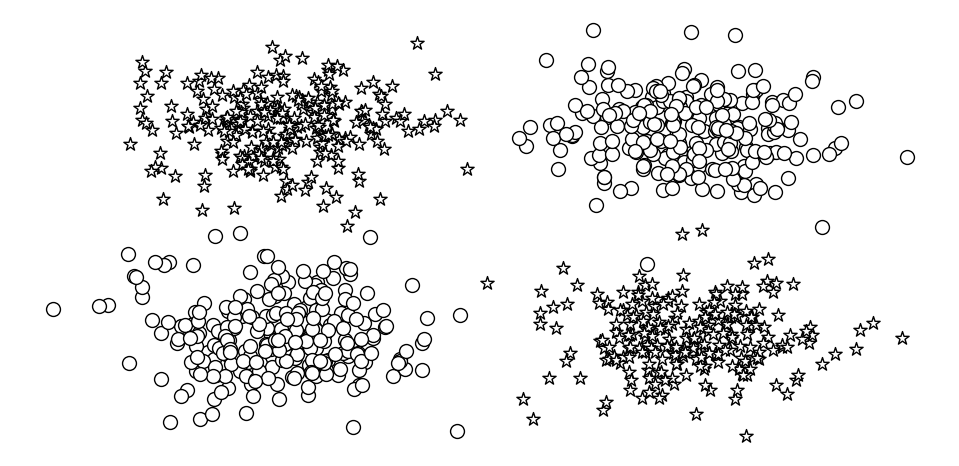

In [101]:
# initial data plot
seed = 24

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

x_data, y_truth = get_toy_data(batch_size=1000)

x_data = x_data.data.cpu().numpy()
y_truth = y_truth.data.cpu().numpy().astype(np.int64)

n_classes = len(set(LABELS))

all_x = [[] for _ in range(n_classes)]
all_colors = [[] for _ in range(n_classes)]

colors = ['black', 'white']
markers = ['o', '*']

for x_i, y_true_i in zip(x_data, y_truth):
    all_x[y_true_i].append(x_i)
    all_colors[y_true_i].append(colors[y_true_i])

all_x = [np.stack(x_list) for x_list in all_x]

_, ax = plt.subplots(1, 1, figsize=(10, 5))

for x_list, color_list, marker in zip(all_x, all_colors, markers):
    ax.scatter(x_list[:, 0], x_list[:, 1], edgecolor='black', marker=marker, facecolor="white", s=100)

plt.tight_layout()
plt.axis('off')

plt.title("")

plt.savefig("./images/data.png")
plt.savefig("./images/data.pdf")

MultilayerPerceptron(
  (module_list): ModuleList()
  (fc_final): Linear(in_features=2, out_features=2, bias=True)
)


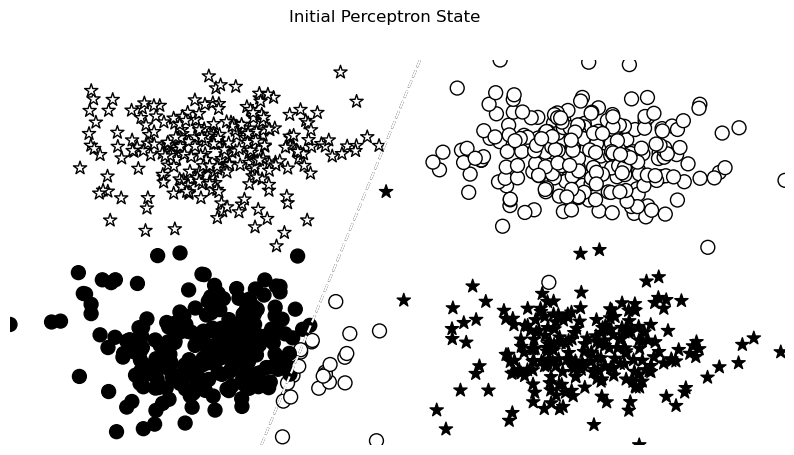

In [102]:
# Training a Perceptron
input_size = 2
output_size = len(set(LABELS))
num_hidden_layers = 0
hidden_size = 2  # isn't ever used but we still set it

seed = 24

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

mlp1 = MultilayerPerceptron(input_size=input_size,
                            hidden_size=hidden_size,
                            num_hidden_layers=num_hidden_layers,
                            output_size=output_size)
mlp1.to(device)
print(mlp1)
batch_size = 1000

x_data_static, y_truth_static = get_toy_data(batch_size)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
visualize_results(mlp1, x_data_static, y_truth_static,
                  ax=ax, title='Initial Perceptron State', levels=[0.5])

plt.axis('off')
plt.savefig('images/perceptron_initial.png')

In [ ]:
losses = []
batch_size = 10000
n_batches = 10
max_epochs = 10

loss_change = 1.0
last_loss = 10.0
change_threshold = 1e-3
epoch = 0
all_imagefiles = []

lr = 0.01
optimizer = optim.Adam(params=mlp1.parameters(), lr=lr)
cross_ent_loss = nn.CrossEntropyLoss()


def early_termination(loss_change, change_threshold, epoch, max_epochs):
    terminate_for_loss_change = loss_change < change_threshold
    terminate_for_epochs = epoch > max_epochs

    #return terminate_for_loss_change or
    return terminate_for_epochs


while not early_termination(loss_change, change_threshold, epoch, max_epochs):
    for _ in range(n_batches):
        # step 0: fetch the data
        x_data, y_target = get_toy_data(batch_size)

        # step 1: zero the gradients
        mlp1.zero_grad()

        # step 2: run the forward pass
        y_pred = mlp1(x_data).squeeze()

        # step 3: compute the loss
        loss = cross_ent_loss(y_pred, y_target.long())

        # step 4: compute the backward pass
        loss.backward()

        # step 5: have the optimizer take an optimization step
        optimizer.step()

        # auxillary: bookkeeping
        loss_value = loss.item()
        losses.append(loss_value)
        loss_change = abs(last_loss - loss_value)
        last_loss = loss_value

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    visualize_results(mlp1, x_data_static, y_truth_static, ax=ax, epoch=epoch,
                      title=f"loss: {loss_value:0.2f}; change: {loss_change:0.4f}")
    plt.axis('off')
    epoch += 1
    all_imagefiles.append(f'./images/perceptron_epoch{epoch}_toylearning.png')
    plt.savefig(all_imagefiles[-1])

In [ ]:
# Training a 2 layer Multilayer Perceptron
input_size = 2
output_size = len(set(LABELS))
num_hidden_layers = 1
hidden_size = 2

seed = 2

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

mlp2 = MultilayerPerceptron(input_size=input_size,
                            hidden_size=hidden_size,
                            num_hidden_layers=num_hidden_layers,
                            output_size=output_size)
mlp2.to(device)
print(mlp2)
batch_size = 1000

x_data_static, y_truth_static = get_toy_data(batch_size)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
visualize_results(mlp2, x_data_static, y_truth_static,
                  ax=ax, title='Initial 2-Layer MLP State', levels=[0.5])

plt.axis('off')
plt.savefig('images/mlp2_initial.png');

In [ ]:
losses = []
batch_size = 10000
n_batches = 10
max_epochs = 15

loss_change = 1.0
last_loss = 10.0
change_threshold = 1e-5
epoch = 0
all_imagefiles = []

lr = 0.01
optimizer = optim.Adam(params=mlp2.parameters(), lr=lr)
cross_ent_loss = nn.CrossEntropyLoss()


def early_termination(loss_change, change_threshold, epoch, max_epochs):
    terminate_for_loss_change = loss_change < change_threshold
    terminate_for_epochs = epoch > max_epochs

    #return terminate_for_loss_change or
    return terminate_for_epochs


while not early_termination(loss_change, change_threshold, epoch, max_epochs):
    for _ in range(n_batches):
        # step 0: fetch the data
        x_data, y_target = get_toy_data(batch_size)

        # step 1: zero the gradients
        mlp2.zero_grad()

        # step 2: run the forward pass
        y_pred = mlp2(x_data).squeeze()

        # step 3: compute the loss
        loss = cross_ent_loss(y_pred, y_target.long())

        # step 4: compute the backward pass
        loss.backward()

        # step 5: have the optimizer take an optimization step
        optimizer.step()

        # auxillary: bookkeeping
        loss_value = loss.item()
        losses.append(loss_value)
        loss_change = abs(last_loss - loss_value)
        last_loss = loss_value

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    visualize_results(mlp2, x_data_static, y_truth_static, ax=ax, epoch=epoch,
                      title=f"loss: {loss_value:0.2f}; change: {loss_change:0.4f}")
    plt.axis('off')
    epoch += 1
    all_imagefiles.append(f'./images/mlp2_epoch{epoch}_toylearning.png')
    plt.savefig(all_imagefiles[-1])

In [ ]:
# Training a 3 layer Multilayer Perceptron
input_size = 2
output_size = len(set(LABELS))
num_hidden_layers = 2
hidden_size = 2

seed = 399

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

mlp3 = MultilayerPerceptron(input_size=input_size,
                            hidden_size=hidden_size,
                            num_hidden_layers=num_hidden_layers,
                            output_size=output_size)
mlp3.to(device)
print(mlp3)
batch_size = 1000

x_data_static, y_truth_static = get_toy_data(batch_size)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
visualize_results(mlp3, x_data_static, y_truth_static,
                  ax=ax, title='Initial 3-Layer MLP State', levels=[0.5])

plt.axis('off')
plt.savefig('images/mlp3_initial.png');

In [ ]:
losses = []
batch_size = 10000
n_batches = 10
max_epochs = 10

loss_change = 1.0
last_loss = 10.0
change_threshold = 1e-5
epoch = 0
all_imagefiles = []

lr = 0.01
optimizer = optim.Adam(params=mlp3.parameters(), lr=lr)
cross_ent_loss = nn.CrossEntropyLoss()


def early_termination(loss_change, change_threshold, epoch, max_epochs):
    terminate_for_loss_change = loss_change < change_threshold
    terminate_for_epochs = epoch > max_epochs

    #return terminate_for_loss_change or
    return terminate_for_epochs


while not early_termination(loss_change, change_threshold, epoch, max_epochs):
    for _ in range(n_batches):
        # step 0: fetch the data
        x_data, y_target = get_toy_data(batch_size)

        # step 1: zero the gradients
        mlp3.zero_grad()

        # step 2: run the forward pass
        y_pred = mlp3(x_data).squeeze()

        # step 3: compute the loss
        loss = cross_ent_loss(y_pred, y_target.long())

        # step 4: compute the backward pass
        loss.backward()

        # step 5: have the optimizer take an optimization step
        optimizer.step()

        # auxillary: bookkeeping
        loss_value = loss.item()
        losses.append(loss_value)
        loss_change = abs(last_loss - loss_value)
        last_loss = loss_value

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    visualize_results(mlp3, x_data_static, y_truth_static, ax=ax, epoch=epoch,
                      title=f"loss: {loss_value:0.2f}; change: {loss_change:0.4f}")
    plt.axis('off')
    epoch += 1
    all_imagefiles.append(f'./images/mlp3_epoch{epoch}_toylearning.png')
    plt.savefig(all_imagefiles[-1])

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))
visualize_results(mlp1, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=ax)
plt.axis('off');
plt.savefig('./images/perceptron_final.png')

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))
visualize_results(mlp2, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=ax)
plt.axis('off');
plt.savefig('./images/mlp2_final.png')

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))
visualize_results(mlp3, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=ax)
plt.axis('off');
plt.savefig('./images/mlp3_final.png')

In [ ]:
_, axes = plt.subplots(1, 2, figsize=(12, 5))
visualize_results(mlp1, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=axes[0])
visualize_results(mlp2, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=axes[1])
plt.tight_layout()
axes[0].axis('off');
axes[1].axis('off');
plt.savefig("./images/perceptron_vs_mlp2.png")
plt.savefig("./images/figure_4_3.pdf")

In [ ]:
_, axes = plt.subplots(1, 2, figsize=(12, 5))
visualize_results(mlp1, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=axes[0])
visualize_results(mlp3, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=axes[1])
plt.tight_layout()
axes[0].axis('off');
axes[1].axis('off');
plt.savefig("./images/perceptron_vs_mlp3.png")

In [ ]:
_, axes = plt.subplots(1, 3, figsize=(16, 5))
visualize_results(mlp1, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=axes[0])
visualize_results(mlp2, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=axes[1])
visualize_results(mlp3, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=axes[2])
plt.tight_layout()
axes[0].axis('off');
axes[1].axis('off');
axes[2].axis('off');
plt.savefig("./images/perceptron_vs_mlp2_vs_mlp3.png")

In [ ]:
# Inspecting the representations
batch_size = 100


def plot_intermediate_representations(mlp_model, plot_title, figsize=(10, 2)):
    x_data, y_target = get_toy_data(batch_size)

    y_pred = mlp_model(x_data, True).cpu().detach().numpy()

    x_data = x_data.cpu().numpy()
    y_target = y_target.cpu().numpy()

    colors = ['black', 'white']
    markers = ['o', '*']

    #     plot_colors = []
    #     for i in range(y_target.shape[0]):
    #         plot_colors.append(colors[y_target[i]])

    plot_markers = []
    class_zero_indices = []
    class_one_indices = []
    for i in range(y_target.shape[0]):
        if y_target[i] == 0:
            class_zero_indices.append(i)
        else:
            class_one_indices.append(i)
    class_zero_indices = np.array(class_zero_indices)
    class_one_indices = np.array(class_one_indices)
    # plot_markers.append(markers[y_target[i]])

    fig, axes = plt.subplots(1, len(mlp_model.last_forward_cache), figsize=figsize)

    for class_index, data_indices in enumerate([class_zero_indices, class_one_indices]):

        axes[0].scatter(x_data[data_indices, 0], x_data[data_indices, 1], edgecolor='black', facecolor="white",
                        marker=markers[class_index], s=[200, 400][class_index])
        axes[0].axis('off')
        for i, activations in enumerate(mlp_model.last_forward_cache[1:], 1):
            axes[i].scatter(activations[data_indices, 0], activations[data_indices, 1], edgecolor='black',
                            facecolor="white",
                            marker=markers[class_index], s=[200, 400][class_index])
            axes[i].axis('off')

    plt.tight_layout()

    plt.suptitle(plot_title, size=15)
    plt.subplots_adjust(top=0.75)

In [ ]:
plot_intermediate_representations(mlp1,
                                  "The Perceptron's Input and Intermediate Representation",
                                  figsize=(9, 3))
plt.savefig("./images/perceptron_intermediate.png")
plt.savefig("./images/figure_4_5.pdf")

In [ ]:
plot_intermediate_representations(mlp2,
                                  "A 2-layer MLP's Input and Intermediate Representation",
                                  figsize=(10, 3))
plt.savefig("./images/mlp2_intermediate.png")
plt.savefig("./images/figure_4_4.pdf")

In [ ]:
plot_intermediate_representations(mlp3,
                                  "The 3-layer Multilayer Perceptron's Input and Intermediate Representation",
                                  figsize=(13, 3))
plt.savefig("./images/mlp3_intermediate.png")
plt.savefig("./images/mlp3_intermediate.pdf")